In [99]:
# 
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('dark_background')

num_epochs = 20
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length


In [100]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

X, y = generateData()

In [101]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes), dtype=tf.float32)
b2 = tf.Variable(np.zeros((1, num_classes)), dtype=tf.float32)

# unstack
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [102]:
# forward pass
current_state = init_state
states_series = []
for current_input in inputs_series: 
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1) # increasing number of columns
    
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b) # broadcasted addition
    states_series.append(next_state)
    current_state = next_state
    
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) 
          for logits, labels in zip(logits_series, labels_series)]
total_loss = tf.reduce_mean(losses) 
    
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)


In [103]:
def plot(loss_list, predictions_series, batchX, batchY): 
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)
    
    for batch_series_idx in range(5): 
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])
        
        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")
        
    plt.draw()
    plt.pause(0.0001)



<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Loss 0.71240044


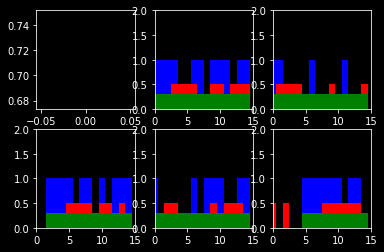

Step 600 Loss 0.6922877


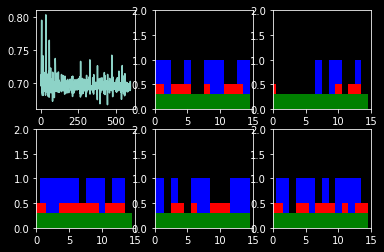

New data, epoch 1
Step 0 Loss 0.70214343


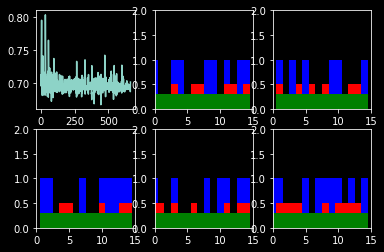

Step 600 Loss 0.6910239


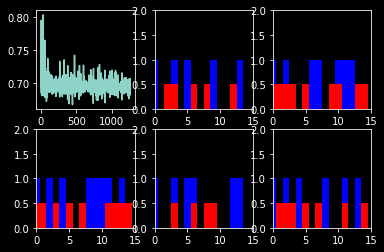

New data, epoch 2
Step 0 Loss 0.65403277


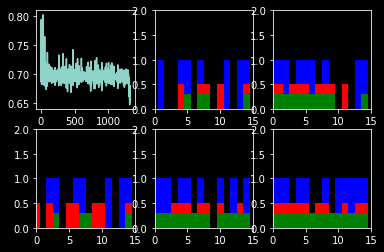

Step 600 Loss 0.0070723193


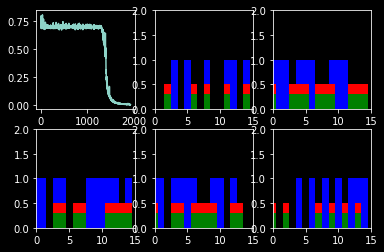

New data, epoch 3
Step 0 Loss 0.18415962


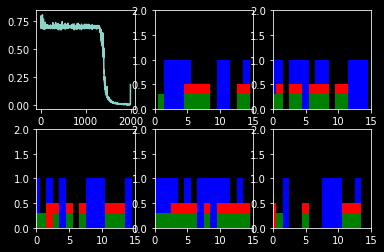

Step 600 Loss 0.002480463


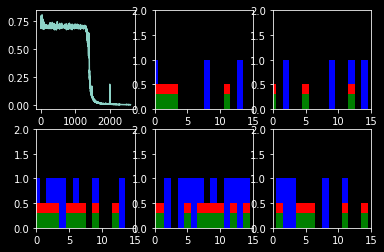

New data, epoch 4
Step 0 Loss 0.17743301


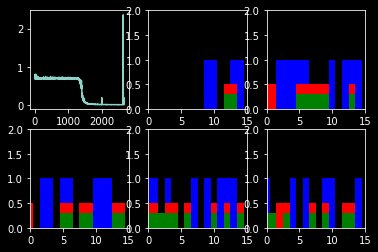

Step 600 Loss 0.0022460115


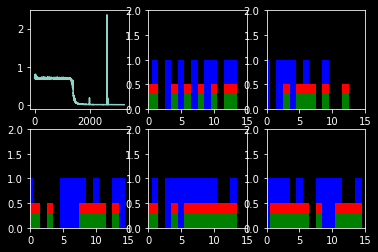

New data, epoch 5
Step 0 Loss 0.26002568


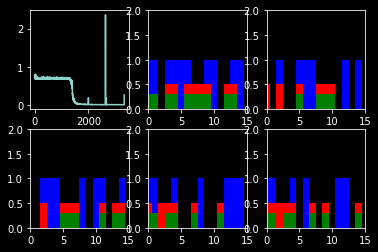

Step 600 Loss 0.0013942986


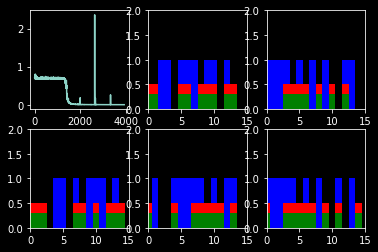

New data, epoch 6
Step 0 Loss 0.2291822


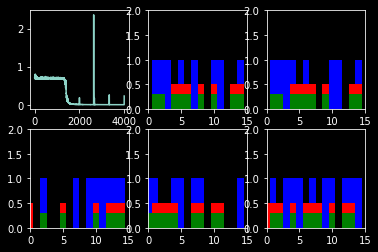

Step 600 Loss 0.0011320353


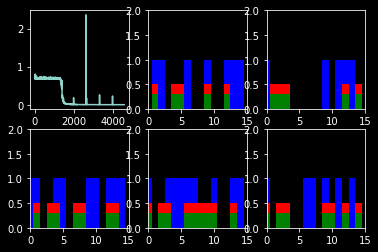

New data, epoch 7
Step 0 Loss 0.18108204


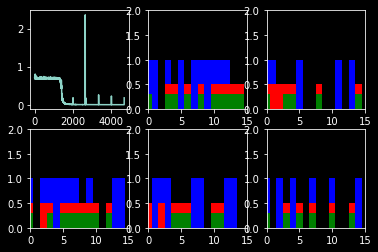

Step 600 Loss 0.0008315269


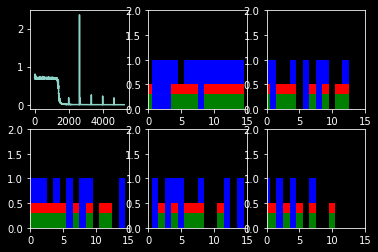

New data, epoch 8
Step 0 Loss 0.18258995


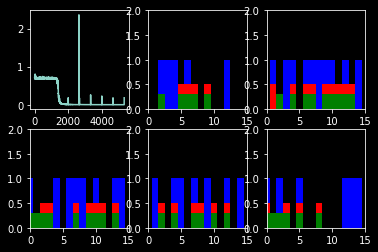

Step 600 Loss 0.0008522472


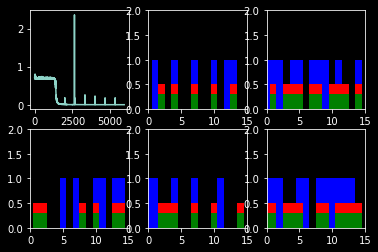

New data, epoch 9
Step 0 Loss 0.20293601


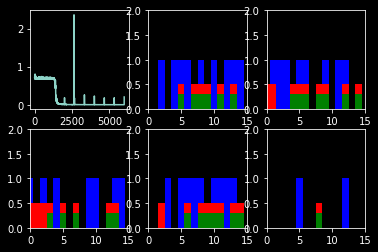

Step 600 Loss 0.00057549984


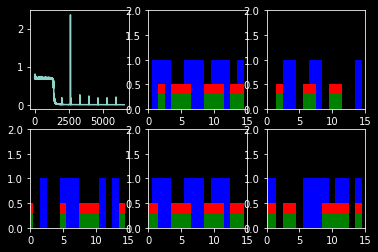

New data, epoch 10
Step 0 Loss 0.18491481


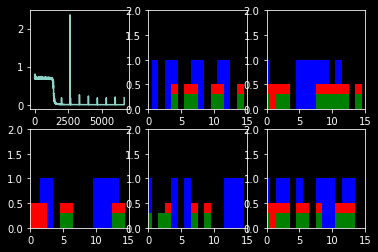

Step 600 Loss 0.00049419457


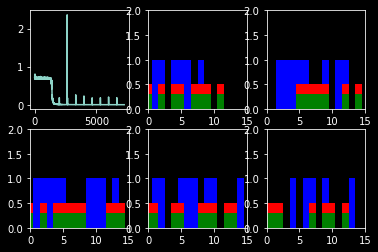

New data, epoch 11
Step 0 Loss 0.12060388


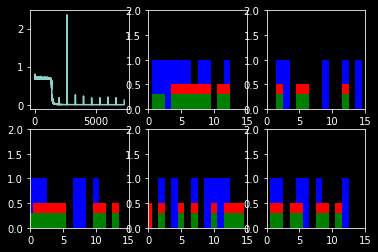

Step 600 Loss 0.0004878548


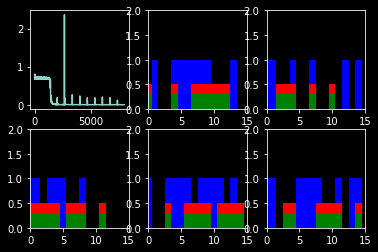

New data, epoch 12
Step 0 Loss 0.093554236


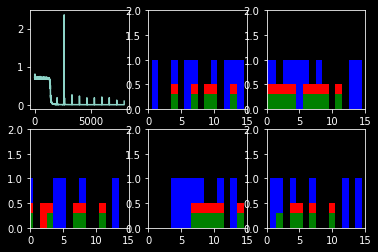

Step 600 Loss 0.00049628166


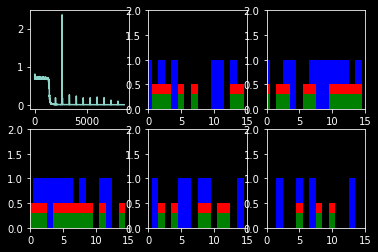

New data, epoch 13
Step 0 Loss 0.2828594


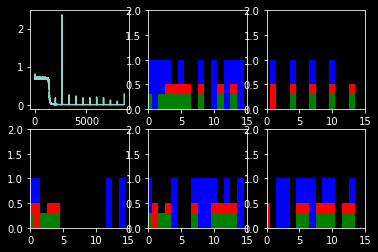

Step 600 Loss 0.00043116108


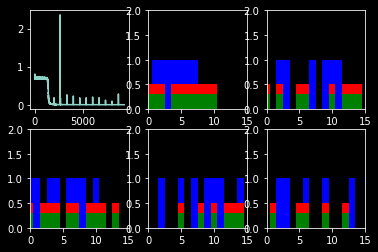

New data, epoch 14
Step 0 Loss 0.26274684


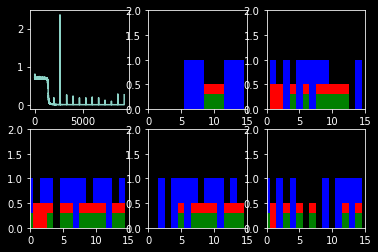

Step 600 Loss 0.0003899468


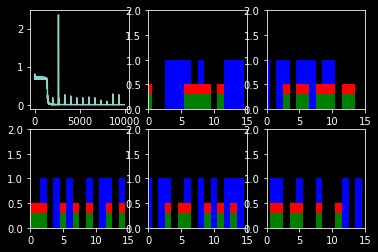

New data, epoch 15
Step 0 Loss 0.23317726


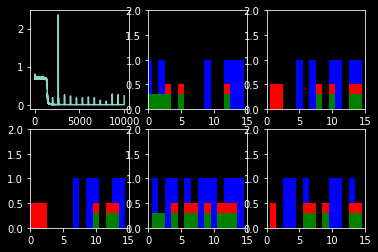

Step 600 Loss 0.0003326319


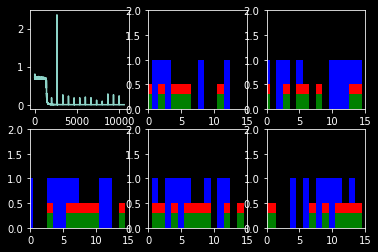

New data, epoch 16
Step 0 Loss 0.19005118


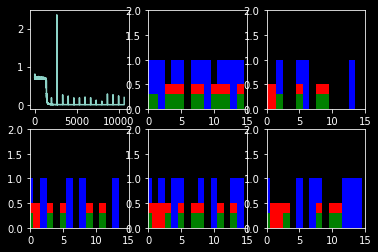

Step 600 Loss 0.00031390353


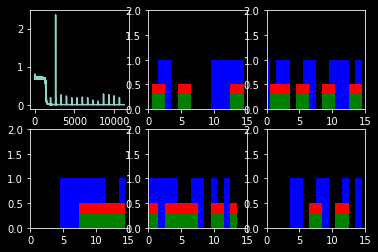

New data, epoch 17
Step 0 Loss 0.18365589


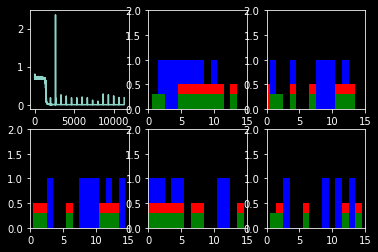

Step 600 Loss 0.0002946553


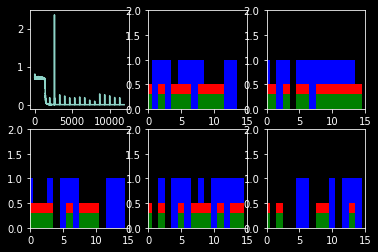

New data, epoch 18
Step 0 Loss 0.19593182


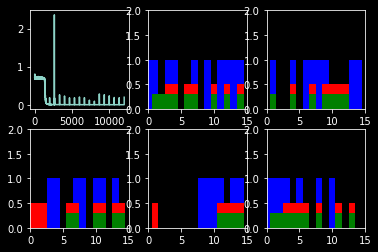

Step 600 Loss 0.00028024617


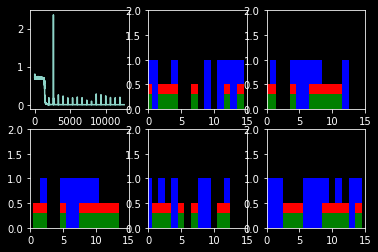

New data, epoch 19
Step 0 Loss 0.5350191


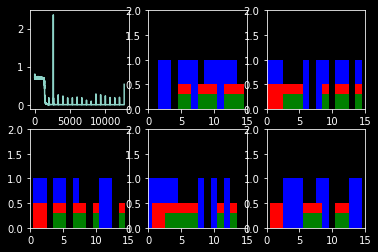

Step 600 Loss 0.00025679896


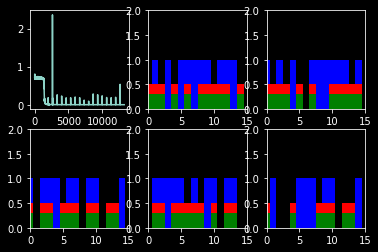

In [104]:
with tf.Session() as sess: 
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []
    
    for epoch_idx in range(num_epochs): 
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))
        
        print("New data, epoch", epoch_idx)
        for batch_idx in range(num_batches): 
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            
            batchX = x[:, start_idx:end_idx]
            batchY = y[:, start_idx:end_idx]
            
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series], 
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })
            
            loss_list.append(_total_loss)
            
            if batch_idx%600 == 0: 
                print("Step", batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()


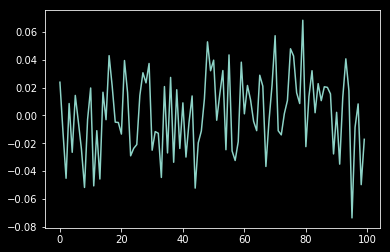

In [107]:
from gensim.models.word2vec import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from typing import List

def make_corp_src(drop_prefix_trash: int = 66, max_lines: int = 1000) -> List[str]:
    with open('bard.txt') as f: 
        return list(filter(lambda s: s[0] not in ['\n', '\r'], [next(f) for x in range(max_lines)]))[drop_prefix_trash:]

SIZE=100
head = make_corp_src()

words = [word_tokenize(text) for text in head]

model = Word2Vec(words, min_count=5, size=SIZE)

plt.plot(range(SIZE), model.wv['love']); 